# 각 학기별로 나눠서 모델링 해보기 

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [3]:
df = pd.read_csv('./data/lets_go.csv')

In [4]:
#df[:2], df.shape

In [5]:
df.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'length',
       'date_registration', 'date_unregistration', 'avg_score',
       'num_assessments', 'total_clicks', 'unique_materials', 'id_assessment'],
      dtype='object')

- code_predsentaiton  : 강의 개설학기 코드 


drop : date_registration, date_unregistration (강의 등록/취소 날짜는 정규 수업들이기 때문에 비슷하다고 판단)

In [6]:
data = df.copy()

In [7]:
# 1. date_registration, date_unregistration 칼럼 삭제
#data.drop(['date_registration', 'date_unregistration'], axis=1, inplace=True)

In [8]:
# 2. 결측치 처리 함수 

data.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                   0
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
length                     0
date_registration          0
date_unregistration        0
avg_score                  0
num_assessments            0
total_clicks               0
unique_materials           0
id_assessment           5847
dtype: int64

In [9]:
ratio = df['id_assessment'].isnull().mean()
print(f"id_assessment 결측치 비율:{ratio:.2%}")

id_assessment 결측치 비율:2.74%


- id_assessment : 과제 인듯? 결측치 약 2.74% 로 행 삭제

In [10]:
#data[:10]

In [11]:
#data[['date_registration','date_unregistration']][:20]


In [12]:
# 각 칼럼별로 unique 값(고유값) 출력 함수

#수치형이 아닌 범주/값 데이터의 결측치 확인 
columns = ['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band','disability', 'final_result' ,
       'num_assessments']


def column_uniques(data):
    for col in columns:
        print(f"/n--- {col} ---")
        print(data[col].unique())


In [13]:
column_uniques(data)

/n--- code_module ---
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
/n--- code_presentation ---
['2013J' '2014J' '2013B' '2014B']
/n--- gender ---
['M' 'F']
/n--- region ---
['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
/n--- highest_education ---
['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
/n--- imd_band ---
['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' '?' '60-70%'
 '40-50%' '10-20' '0-10%']
/n--- age_band ---
['55<=' '35-55' '0-35']
/n--- disability ---
['N' 'Y']
/n--- final_result ---
['Pass' 'Withdrawn' 'Fail' 'Distinction']
/n--- num_assessments ---
[ 5.  0.  2.  4.  1.  3. 11.  6.  9. 10.  7.  8. 13. 12. 14.]


In [14]:
# 데이터 분리

df_2013J = data[data['code_presentation'] == '2013J'].copy()
df_2014J = data[data['code_presentation'] == '2014J'].copy()
df_2013B = data[data['code_presentation'] == '2013B'].copy()
df_2014B = data[data['code_presentation'] == '2014B'].copy()

# 각 데이터프레임 크기 확인
print(f"2013J: {df_2013J.shape}")
print(f"2014J: {df_2014J.shape}")
print(f"2013B: {df_2013B.shape}")
print(f"2014B: {df_2014B.shape}")

2013J: (57657, 20)
2014J: (66927, 20)
2013B: (37130, 20)
2014B: (51452, 20)


In [15]:
# 원-핫 인코딩 함수 
def preprocess_features(data):
    # ----- 매핑 딕셔너리 -----
    gender_map = {'F': 0, 'M': 1}
    disability_map = {'N': 0, 'Y': 1}
    age_band_map = {'0-35': 0, '35-55': 1, '55<=': 2}
    he_map = {
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    }
    imd_map = {
        '0-10%': 1, '10-20': 2, '20-30%': 3, '30-40%': 4, '40-50%': 5,
        '50-60%': 6, '60-70%': 7, '70-80%': 8, '80-90%': 9, '90-100%': 10
    }
    target_map_pass = {'Fail': 2, 'Withdrawn': 1, 'Pass': 0, 'Distinction': 3}

    code_module_map = {
        'AAA': 0, 'BBB': 1, 'CCC': 2, 'DDD': 3,
        'EEE': 4, 'FFF': 5, 'GGG': 6
    }

    region_map = {
        'East Anglian Region': 0,
        'East Midlands Region': 1,
        'Ireland': 2,
        'London Region': 3,
        'North Region': 4,
        'North Western Region': 5,
        'Scotland': 6,
        'South East Region': 7,
        'South Region': 8,
        'South West Region': 9,
        'Wales': 10,
        'West Midlands Region': 11,
        'Yorkshire Region': 12
    }

    # ----- 1) 날짜 컬럼 전처리 -----
    for col in ['date_registration', 'date_unregistration']:
        # '?' → NaN
        data[col] = pd.to_numeric(data[col], errors='coerce')
        # 극단값 (-365 ~ 365)
        data[col] = data[col].clip(lower=-365, upper=365)
        # NaN → 0
        data[col] = data[col].fillna(0)

    # ----- 2) 라벨 인코딩 -----
    data['gender'] = data['gender'].map(gender_map)
    data['disability'] = data['disability'].map(disability_map)
    data['age_band'] = data['age_band'].map(age_band_map)
    data['highest_education'] = data['highest_education'].map(he_map)

    data['imd_band'] = data['imd_band'].replace('?', pd.NA).map(imd_map)
    data = data.dropna(subset=['imd_band'])  # '?'가 있던 행 제거

    data['code_module'] = data['code_module'].map(code_module_map)
    data['region'] = data['region'].map(region_map)

    # ----- 3) 타겟 인코딩 -----
    data['final_result'] = data['final_result'].map(target_map_pass)

    return data

In [16]:
df_2013J = preprocess_features(df_2013J)
df_2014J = preprocess_features(df_2014J)
df_2013B = preprocess_features(df_2013B)
df_2014B = preprocess_features(df_2014B)

In [17]:
# 각 데이터 프레임별 결측치 있는 행 삭제
def drop_missing_rows(dfs):
    for name, data in dfs.items():
        data.dropna(inplace=True)
        print(f"/n{name} 결측치 제거 후 크기: {data.shape}")
    return dfs


In [18]:
dfs = {
    '2013J': df_2013J,
    '2014J': df_2014J,
    '2013B': df_2013B,
    '2014B': df_2014B
}

drop_missing_rows(dfs)

for name, data in dfs.items():
    print(f"/n {name} 결측치 개수")
    print(data.shape)
    print(data.isnull().sum())

/n2013J 결측치 제거 후 크기: (54029, 20)
/n2014J 결측치 제거 후 크기: (61773, 20)
/n2013B 결측치 제거 후 크기: (34444, 20)
/n2014B 결측치 제거 후 크기: (47758, 20)
/n 2013J 결측치 개수
(54029, 20)
code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
length                  0
date_registration       0
date_unregistration     0
avg_score               0
num_assessments         0
total_clicks            0
unique_materials        0
id_assessment           0
dtype: int64
/n 2014J 결측치 개수
(61773, 20)
code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability         

In [19]:
# id_student별 final_result 고유값 개수 계산
student_unique_counts = df_2014J.groupby('id_student')['final_result'].nunique()

# 1) final_result가 모두 동일한 학생만 필터링
#same_final_students = student_unique_counts[student_unique_counts == 1].index
#df_same_final = df[df['id_student'].isin(same_final_students)]

# 2) 동일 / 불일치 학생 수 비교
same_count = (student_unique_counts == 1).sum()
diff_count = (student_unique_counts > 1).sum()

print(f"동일한 final_result만 가진 학생 수: {same_count}")
print(f"다른 final_result도 가진 학생 수: {diff_count}")

# 필요하면 비율도 확인
total_students = len(student_unique_counts)
print(f"동일 비율: {same_count/total_students:.2%}")
print(f"불일치 비율: {diff_count/total_students:.2%}")

동일한 final_result만 가진 학생 수: 8268
다른 final_result도 가진 학생 수: 189
동일 비율: 97.77%
불일치 비율: 2.23%


In [20]:
# id_student별 final_result 고유값 개수 계산
student_unique_counts = df_2014J.groupby('id_student')['final_result'].nunique()

# 동일한 final_result만 가진 학생 id 추출
same_final_students = student_unique_counts[student_unique_counts == 1].index

# 해당 학생들의 데이터만 필터링
df_same_final = df_2014J[df_2014J['id_student'].isin(same_final_students)].copy()

# final_result가 0 또는 1인 학생 id 추출
target_students = df_same_final[df_same_final['final_result'].isin([0, 1])]['id_student'].unique()

# 학생 수 확인
print("final_result가 0 또는 1인 학생 수:", len(target_students))

# 해당 학생들만 필터링
df_target_final = df_same_final[df_same_final['id_student'].isin(target_students)].copy()

final_result가 0 또는 1인 학생 수: 5692


In [21]:


def target_filter(df):
    """
    1) id_student별 final_result가 전 행에서 동일한 학생만 남김
    2) 그 중에서 final_result가 target_values(기본: 0,1)인 학생만 남김

    """
    target_values = (0, 1)  # 기본값 설정
    # id_student별 final_result 고유값 개수
    uc = df.groupby('id_student')['final_result'].nunique()

    # 동일/불일치 학생 수
    same_count = int((uc == 1).sum())
    diff_count = int((uc > 1).sum())
    total = int(len(uc))

    same_ratio = same_count / total if total else 0.0
    diff_ratio = diff_count / total if total else 0.0

    # 동일한 final_result만 가진 학생 id
    same_final_students = uc[uc == 1].index

    # 동일학생만 필터링
    df_same_final = df[df['id_student'].isin(same_final_students)].copy()

    # target_values(기본 0/1)인 학생만 남기기
    target_students = df_same_final[df_same_final['final_result'].isin(target_values)]['id_student'].unique()
    df_target_final = df_same_final[df_same_final['id_student'].isin(target_students)].copy()

    stats = {
        'same_count': same_count,
        'diff_count': diff_count,
        'total': total,
        #'same_ratio': same_ratio,
        #'diff_ratio': diff_ratio,
        'target_student_count': int(len(target_students))
    }
    print(stats)
    #code_presentationz칼럼 삭제
    df_target_final = df_target_final.drop(columns=['code_presentation'], errors='ignore')
    return df_target_final

In [22]:
# 위함수를 df_2014J에 적용
target_2014J = target_filter(df_2014J)

{'same_count': 8268, 'diff_count': 189, 'total': 8457, 'target_student_count': 5692}


In [23]:
# 위 함수를 df_2014J에 적용
target_2014J[30:50]

,code_module,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,length,date_registration,date_unregistration,avg_score,num_assessments,total_clicks,unique_materials,id_assessment
1819,0,55104,0,11,2,7.0,0,0,60,0,0,269,-87.0,0.0,71.0,5.0,1480.0,59.0,1758.0
1820,0,55104,0,11,2,7.0,0,0,60,0,0,269,-87.0,0.0,71.0,5.0,1480.0,59.0,1759.0
1821,0,55104,0,11,2,7.0,0,0,60,0,0,269,-87.0,0.0,71.0,5.0,1480.0,59.0,1760.0
1822,0,55104,0,11,2,7.0,0,0,60,0,0,269,-87.0,0.0,71.0,5.0,1480.0,59.0,1761.0
1823,0,55104,0,11,2,7.0,0,0,60,0,0,269,-87.0,0.0,71.0,5.0,1480.0,59.0,1762.0
1824,0,58071,1,0,3,10.0,2,0,60,0,0,269,-72.0,0.0,76.0,5.0,3648.0,107.0,1758.0
1825,0,58071,1,0,3,10.0,2,0,60,0,0,269,-72.0,0.0,76.0,5.0,3648.0,107.0,1759.0
1826,0,58071,1,0,3,10.0,2,0,60,0,0,269,-72.0,0.0,76.0,5.0,3648.0,107.0,1760.0
1827,0,58071,1,0,3,10.0,2,0,60,0,0,269,-72.0,0.0,76.0,5.0,3648.0,107.0,1761.0
1828,0,58071,1,0,3,10.0,2,0,60,0,0,269,-72.0,0.0,76.0,5.0,3648.0,107.0,1762.0


In [24]:
def make_one_student(df):
    # 집계 방법 지정
    agg_dict = {
        'code_module': 'first',
        'gender': 'first',
        'region': 'first',
        'highest_education': 'first',
        'imd_band': 'first',
        'age_band': 'first',
        'final_result': 'first',
        
        'num_of_prev_attempts': 'sum',  # 누적
        
        'studied_credits': 'mean',      # 평균
        'length': 'mean',
        'avg_score': 'mean',
        'num_assessments': 'mean',
        'total_clicks': 'mean',
        'unique_materials': 'mean',
        'id_assessment': 'mean',
        
        'date_registration': 'min',     # 날짜 처리
        'date_unregistration': 'max'
    }
    
    # 그룹화
    result = df.groupby('id_student', as_index=False).agg(agg_dict)
    
    # 학생 수 출력
    print("최종 행(학생 수):", len(result))
    
    return result

In [25]:
df_2014J_student = make_one_student(target_2014J)

최종 행(학생 수): 5692


# 2. 데이터 전처리 완료 -> 분리 예측 진행
- 2014J로 진행 
- 목표(Target): final_result (0=Pass, 1=Withdrawn)



[나중에 해볼것 ]
1. stratify 해보기 

In [26]:
# 데이터 분리 & 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score

# 분류 모델들
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# 부스팅 계열
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [28]:
print(df_2014J_student['final_result'].unique())

#df_2014J_student[:10]

[0 1]


In [29]:
## 1. 데이터 준비 / taget 분리 

X = df_2014J_student.drop(columns=['final_result'])
y = df_2014J_student['final_result']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
# === 1. 비교 모델 세트 ===
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),  
    #"KNN": KNeighborsClassifier(n_neighbors=5),      
    #"LinearSVM": SVC(kernel="linear", probability=True, random_state=42),
    "GNB": GaussianNB(),
    "XGBoost": XGBClassifier(
        random_state=42,
        eval_metric="logloss"
    )
}

In [32]:

# --- 2) 학습 & 평가 유틸 ---
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

# --- 3) 전체 모델 실행 ---
rows = []
reports = {}
for name, m in models.items():
    try:
        row, rep = eval_model(name, m, X_train, y_train, X_test, y_test)
        rows.append(row)
        reports[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (no stratify, no scaling) ===")
print(df_results.to_string(index=False))

best_model_name = df_results.iloc[0]["Model"]
print(f"/nBest (by ROC-AUC): {best_model_name}")

=== Model comparison (no stratify, no scaling) ===
           Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP  TN  FN
    RandomForest  1.000000      1.000000   1.000000 1.000000 1.000000 359   0 780   0
         XGBoost  1.000000      1.000000   1.000000 1.000000 1.000000 359   0 780   0
GradientBoosting  1.000000      1.000000   1.000000 1.000000 1.000000 359   0 780   0
    DecisionTree  0.999122      0.997222   1.000000 0.998609 0.999359 359   1 779   0
             GNB  0.964004      0.981818   0.902507 0.940493 0.993129 324   6 774  35
/nBest (by ROC-AUC): RandomForest


In [33]:
# 성능확인

def train_test_gap(model, X_tr, y_tr, X_te, y_te, name="model"):
    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    tr_acc = accuracy_score(y_tr, y_tr_pred)
    te_acc = accuracy_score(y_te, y_te_pred)
    tr_f1  = f1_score(y_tr, y_tr_pred, average="macro")
    te_f1  = f1_score(y_te, y_te_pred, average="macro")

    print(f"[{name}]")
    print(f"  Train  Acc={tr_acc:.4f} | F1(macro)={tr_f1:.4f}")
    print(f"  Test   Acc={te_acc:.4f} | F1(macro)={te_f1:.4f}")
    print(f"  Gap    Acc={tr_acc - te_acc:.4f} | F1={tr_f1 - te_f1:.4f}")
    return {
        "Model": name, "Train_Acc": tr_acc, "Test_Acc": te_acc, "Gap_Acc": tr_acc-te_acc,
        "Train_F1": tr_f1, "Test_F1": te_f1, "Gap_F1": tr_f1-te_f1
    }

# 여러 모델 한 번에 확인
gap_rows = []
for name, clf in models.items():
    try:
        gap_rows.append(train_test_gap(clf, X_train, y_train, X_test, y_test, name))
    except Exception as e:
        print(f"[WARN] {name} 스킵: {e}")

pd.DataFrame(gap_rows).sort_values("Gap_Acc", ascending=False)

[DecisionTree]
  Train  Acc=1.0000 | F1(macro)=1.0000
  Test   Acc=0.9991 | F1(macro)=0.9990
  Gap    Acc=0.0009 | F1=0.0010
[RandomForest]
  Train  Acc=1.0000 | F1(macro)=1.0000
  Test   Acc=1.0000 | F1(macro)=1.0000
  Gap    Acc=0.0000 | F1=0.0000
[GradientBoosting]
  Train  Acc=1.0000 | F1(macro)=1.0000
  Test   Acc=1.0000 | F1(macro)=1.0000
  Gap    Acc=0.0000 | F1=0.0000
[GNB]
  Train  Acc=0.9682 | F1(macro)=0.9622
  Test   Acc=0.9640 | F1(macro)=0.9573
  Gap    Acc=0.0041 | F1=0.0048
[XGBoost]
  Train  Acc=1.0000 | F1(macro)=1.0000
  Test   Acc=1.0000 | F1(macro)=1.0000
  Gap    Acc=0.0000 | F1=0.0000


,Model,Train_Acc,Test_Acc,Gap_Acc,Train_F1,Test_F1,Gap_F1
3,GNB,0.968153,0.964004,0.004149,0.962191,0.957346,0.004845
0,DecisionTree,1.000000,0.999122,0.000878,1.000000,0.998984,0.001016
1,RandomForest,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
2,GradientBoosting,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
4,XGBoost,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000


##  변수별 영향도


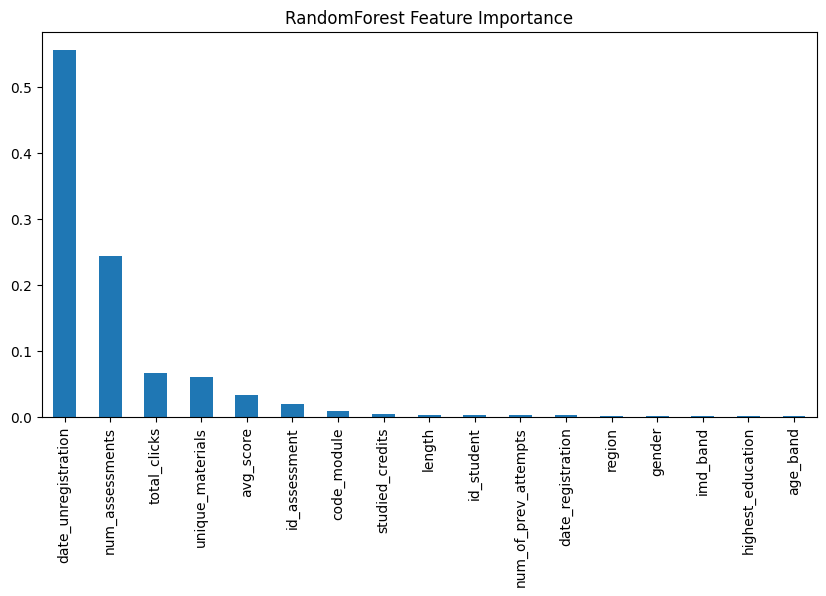

In [34]:
# 트리기반
import pandas as pd
import matplotlib.pyplot as plt

# 예: RandomForest로 변수 중요도 보기
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("RandomForest Feature Importance")
plt.show()

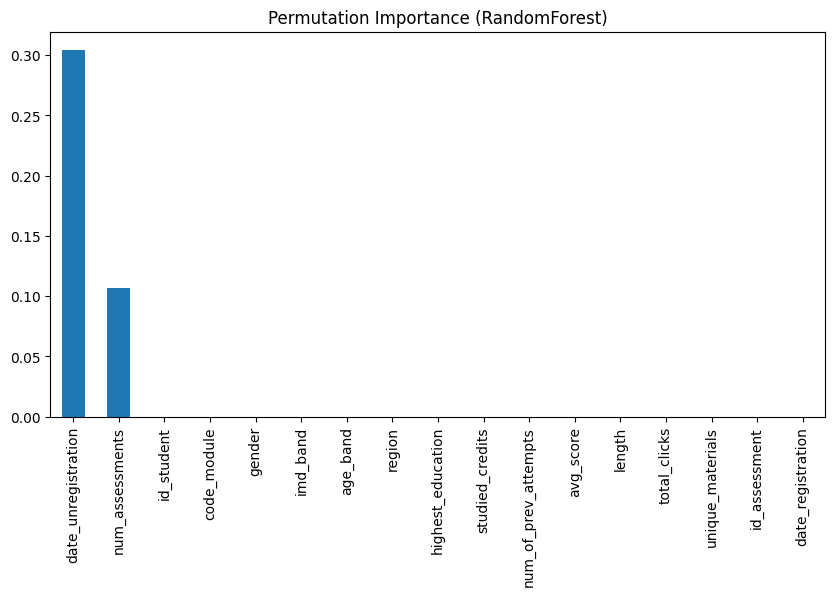

In [35]:
from sklearn.inspection import permutation_importance

rf.fit(X_train, y_train)
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)
perm_df.plot(kind='bar', figsize=(10,5))
plt.title("Permutation Importance (RandomForest)")
plt.show()

- date_unregistration : 수강 취소한 학생은 당연히 드랍할 확률이 높음 -> 강한 경향성 (해당 변수에 강하게 의존함))

In [36]:
# date_unregistration 와 타겟 칼럼의 분포확인

# date_unregistration 값 유무에 따라 final_result 분포 확인
df_2014J_student['has_unreg'] = df_2014J_student['date_unregistration'].notnull().astype(int)

print("=== date_unregistration 값 유무별 final_result 분포 ===")
print(pd.crosstab(df_2014J_student['has_unreg'], df_2014J_student['final_result'], normalize='index') * 100)

=== date_unregistration 값 유무별 final_result 분포 ===
final_result          0          1
has_unreg                         
1             68.745608  31.254392


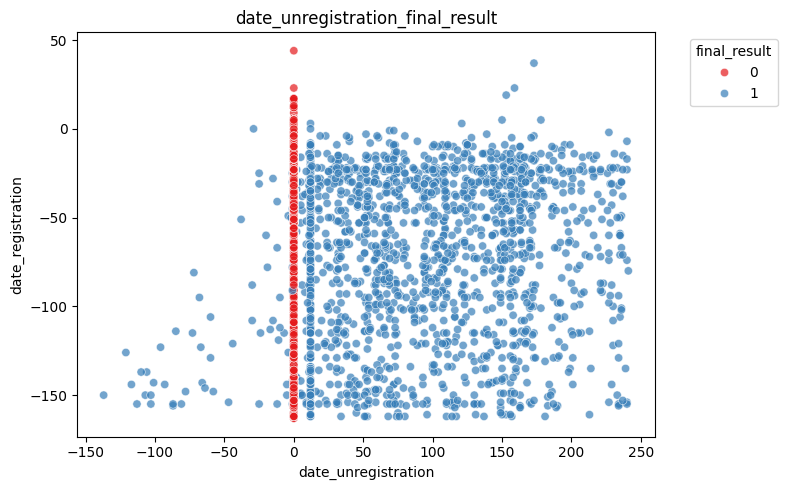

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_2014J_student,
    x="date_unregistration",
    y="date_registration",  # 참고로 y축은 다른 수치형 변수 사용 (예: date_registration)
    hue="final_result",     # final_result에 따라 색상 구분
    palette="Set1",
    alpha=0.7
)
plt.title("date_unregistration_final_result")
plt.xlabel("date_unregistration")
plt.ylabel("date_registration")  # 필요에 맞게 변경 가능
plt.legend(title="final_result", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### date_unregistration제외한 모델 성능 비교

In [38]:
# === 1. date_unregistration 제거 ===
X_train_no_unreg = X_train.drop(columns=['date_unregistration'])
X_test_no_unreg = X_test.drop(columns=['date_unregistration'])

# === 2. 모델 학습 & 평가 ===
rows_no_unreg = []
reports_no_unreg = {}

for name, m in models.items():
    try:
        row, rep = eval_model(name, m, 
                              X_train_no_unreg, y_train, 
                              X_test_no_unreg, y_test)
        rows_no_unreg.append(row)
        reports_no_unreg[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results_no_unreg = pd.DataFrame(rows_no_unreg).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (date_unregistration 제거 후) ===")
print(df_results_no_unreg.to_string(index=False))

# === 3. 성능 변화 비교 ===
df_compare = df_results[['Model', 'ROC-AUC']].merge(
    df_results_no_unreg[['Model', 'ROC-AUC']], 
    on='Model', 
    suffixes=('_with', '_without')
)
df_compare['ROC-AUC_drop'] = df_compare['ROC-AUC_with'] - df_compare['ROC-AUC_without']
print("\n=== ROC-AUC 변화량 ===")
print(df_compare.to_string(index=False))

=== Model comparison (date_unregistration 제거 후) ===
           Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP  TN  FN
GradientBoosting  0.980685      0.982808   0.955432 0.968927 0.997186 343   6 774  16
         XGBoost  0.978929      0.974504   0.958217 0.966292 0.995257 344   9 771  15
    RandomForest  0.968393      0.968116   0.930362 0.948864 0.994593 334  11 769  25
    DecisionTree  0.967515      0.942308   0.955432 0.948824 0.964254 343  21 759  16
             GNB  0.806848      0.650759   0.835655 0.731707 0.893122 300 161 619  59

=== ROC-AUC 변화량 ===
           Model  ROC-AUC_with  ROC-AUC_without  ROC-AUC_drop
    RandomForest      1.000000         0.994593      0.005407
         XGBoost      1.000000         0.995257      0.004743
GradientBoosting      1.000000         0.997186      0.002814
    DecisionTree      0.999359         0.964254      0.035105
             GNB      0.993129         0.893122      0.100007


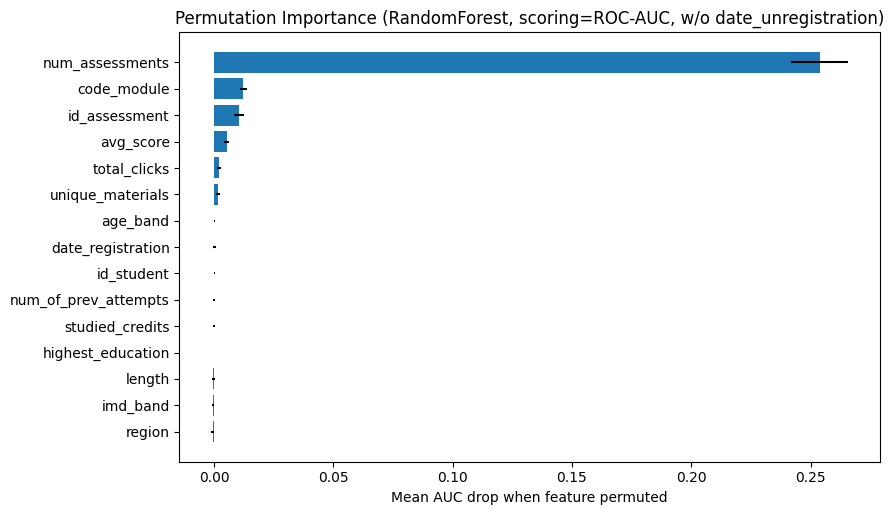

,importance_mean,importance_std
num_assessments,0.253880,0.011883
code_module,0.012340,0.001557
id_assessment,0.010537,0.001976
avg_score,0.005360,0.001102
total_clicks,0.001995,0.000764
unique_materials,0.001732,0.000824
age_band,0.000131,0.000088
date_registration,0.000074,0.000575
id_student,0.000031,0.000195
num_of_prev_attempts,-0.000080,0.000331


In [39]:


# 1) 사용할 특징 컬럼 선택 (원하면 date_unregistration 제외)
cols_for_pi = list(X_test.columns)
if "date_unregistration" in cols_for_pi:
    cols_for_pi.remove("date_unregistration")

# 2) 모델 학습 (이미 학습되어 있으면 생략 가능)
rf.fit(X_train[cols_for_pi], y_train)

# 3) Permutation Importance 계산 (ROC-AUC 기준)
pi = permutation_importance(
    rf,
    X_test[cols_for_pi],
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

# 4) 결과 정리 (mean, std)
imp_mean = pd.Series(pi.importances_mean, index=cols_for_pi)
imp_std  = pd.Series(pi.importances_std,  index=cols_for_pi)
perm_df  = pd.DataFrame({"importance_mean": imp_mean, "importance_std": imp_std}) \
             .sort_values("importance_mean", ascending=False)

# 5) 상위 K개만 시각화
K = 15
topk = perm_df.head(K)[::-1]  # 그래프에서 위가 중요하게 보이도록 역순

plt.figure(figsize=(9, max(4, K*0.35)))
plt.barh(topk.index, topk["importance_mean"], xerr=topk["importance_std"])
plt.title("Permutation Importance (RandomForest, scoring=ROC-AUC, w/o date_unregistration)")
plt.xlabel("Mean AUC drop when feature permuted")
plt.tight_layout()
plt.show()

# 6) 표 형태로 상위 K개 확인
display(perm_df.head(K))

In [41]:
# === 1. date_unregistration 제거 ===
X_train_no_unreg = X_train.drop(columns=['date_unregistration', 'num_assessments'])
X_test_no_unreg = X_test.drop(columns=['date_unregistration', 'num_assessments'])

# === 2. 모델 학습 & 평가 ===
rows_no_unreg = []
reports_no_unreg = {}

for name, m in models.items():
    try:
        row, rep = eval_model(name, m, 
                              X_train_no_unreg, y_train, 
                              X_test_no_unreg, y_test)
        rows_no_unreg.append(row)
        reports_no_unreg[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results_no_unreg = pd.DataFrame(rows_no_unreg).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (date_unregistration , num_assessments 제거 후) ===")
print(df_results_no_unreg.to_string(index=False))

# === 3. 성능 변화 비교 ===
df_compare = df_results[['Model', 'ROC-AUC']].merge(
    df_results_no_unreg[['Model', 'ROC-AUC']], 
    on='Model', 
    suffixes=('_with', '_without')
)
df_compare['ROC-AUC_drop'] = df_compare['ROC-AUC_with'] - df_compare['ROC-AUC_without']
print("/n=== ROC-AUC 변화량 ===")
print(df_compare.to_string(index=False))

=== Model comparison (date_unregistration , num_assessments 제거 후) ===
           Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP  TN  FN
         XGBoost  0.963126      0.936639   0.947075 0.941828 0.991629 340  23 757  19
GradientBoosting  0.956102      0.947826   0.910864 0.928977 0.989242 327  18 762  32
    RandomForest  0.935031      0.913043   0.877437 0.894886 0.977866 315  30 750  44
    DecisionTree  0.937665      0.895604   0.908078 0.901798 0.929680 326  38 742  33
             GNB  0.804214      0.647186   0.832869 0.728380 0.889201 299 163 617  60
/n=== ROC-AUC 변화량 ===
           Model  ROC-AUC_with  ROC-AUC_without  ROC-AUC_drop
    RandomForest      1.000000         0.977866      0.022134
         XGBoost      1.000000         0.991629      0.008371
GradientBoosting      1.000000         0.989242      0.010758
    DecisionTree      0.999359         0.929680      0.069679
             GNB      0.993129         0.889201      0.103928
